---
# Sustained Radiation Events (SREs) - PV Power Generation Analysis
---
This notebook provides the analysis how much PV power is generated during SREs on a local scale. 

The data used in this notebook are from CMIP6 Climate models.

The Global Solar Energy Estimator (GSEE) is used to estimate how much PV power is generated given specific parameters.

Copyright (c) 2023, ETH Zurich, Guillaume Senger

In [1]:
import my_functions
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import pickle
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns
import matplotlib.ticker as ticker
from scipy.stats import pearsonr

matplotlib.rcParams.update({'font.size': 22})

---
## Loading Data and Compute SREs

We are loading our SSR time series and PV powers as well as computing SREs on the SSR time series.

In [3]:
location      = 'Zurich'    # Choose location of interest
model_name    = 'GFDL-ESM4' # Choose climate model of interest
percentiles   = [10, 90]    # Choose percentiles of interest (2 complementary percentiles only)

rsds_models    = pickle.load(open(f'Data/rsds/{location}.pickle', 'rb')) # Load data created using the script Get_Data_Local.py
rsds           = rsds_models[model_name]                                 # Get time series for model_name

n_years = len(rsds)//365 # Get simulation length in years

seasons, masks   = my_functions.get_seasons_masks(n_years) # Load the season masks

output_SREs       = my_functions.compute_SREs(time_series=rsds, percentiles=percentiles)  # type: ignore # Compute the SREs on the SSR time series

# Choose PV installation configurations
configs       = {0: {'tilt': 35, 'azim': 180, 'tracking': 0}, # Configuration 0: south and normal tilt
                 1: {'tilt': 55, 'azim': 180, 'tracking': 0}  # Configuration 1: south and strong tilt
                 }

pv_powers = {} # Empty dictionnary to store the previously loaded PV power for our configurations

for num_config, config_details in configs.items():

    tilt     = config_details['tilt']
    azim     = config_details['azim']
    tracking = config_details['tracking']

    pv_powers[num_config] = pickle.load(open(f'Data/PV/{model_name}_{location}_tilt_{tilt}_azim_{azim}_tracking_{tracking}.pickle', 'rb')) # Load data created using the script Get_PV_Power.py

SUSTAINED RADIATION EVENTS
--------------------------
Time series duration: 500 years (182500 days)

Percentiles considered: [10, 90]

SREs lengths considered:
      mininum  3 consecutive days
      maxinum 16 consecutive days

For each percentile, available outputs are:
          - thresholds_all_years (182500,): give the daily thresholds for all simulation days
          - rsds_all_years_above (182500,): binary array with 1: exceed daily threshold, 0: do not exceed daily threshold
          - SREs_all_years (182500,): give the SRE length at the first day of all SREs, 0 otherwise
          - extreme_events_per_day (365, 17): give how many events of length L are observed for each calendar day

SREs computed successfully.


---
## L-Day Mean Computation

We are computing the mean SSR and PV power during all SREs observed.

In [21]:
# Empty dictionnaries to store the results
power_waves_mean              = {percentile: {} for percentile in percentiles}
rsds_waves_mean               = {}

for p_index, percentile in enumerate(percentiles):

    rsds_all_years_above_percentile   = output_SREs[percentile]['rsds_all_years_above']   # Get array with 1 if above threshold and 0 if below  
    SREs_all_years                    = output_SREs[percentile]['SREs_all_years']         # Get array with SREs length
    indices = np.where(SREs_all_years < 3)[0]                                             # Get all days without a SREs of 3 or more consecutive days

    # Compute the L-days mean SSR during each SRE
    rsds_waves                  = rsds * rsds_all_years_above_percentile                   # Array with rsds only if above threshold and 0 otherwise
    rsds_waves_mean[percentile] = my_functions.compute_group_means_and_replace(rsds_waves) # Array with L-day mean rsds at the first day of each rsds group
    rsds_waves_mean[percentile][indices] = np.nan                                          # Only keep the mean of groups of at least 3 consecutive days

    for num_config, config_details in configs.items():
    
        # Compute the L-days mean PV power during each SRE for each configuration
        power_waves                               = pv_powers[num_config] * rsds_all_years_above_percentile   # Array with PV power only if above threshold and 0 otherwise
        power_waves_mean[percentile][num_config]  = my_functions.compute_group_means_and_replace(power_waves) # Array with L-day mean PV power at the first day of each PV power group
        power_waves_mean[percentile][num_config][indices] = np.nan                                            # Only keep the mean of groups of at least 3 consecutive days            


---
## Results Visualisation

We plot for each SREs the mean PV power vs. mean SSR .

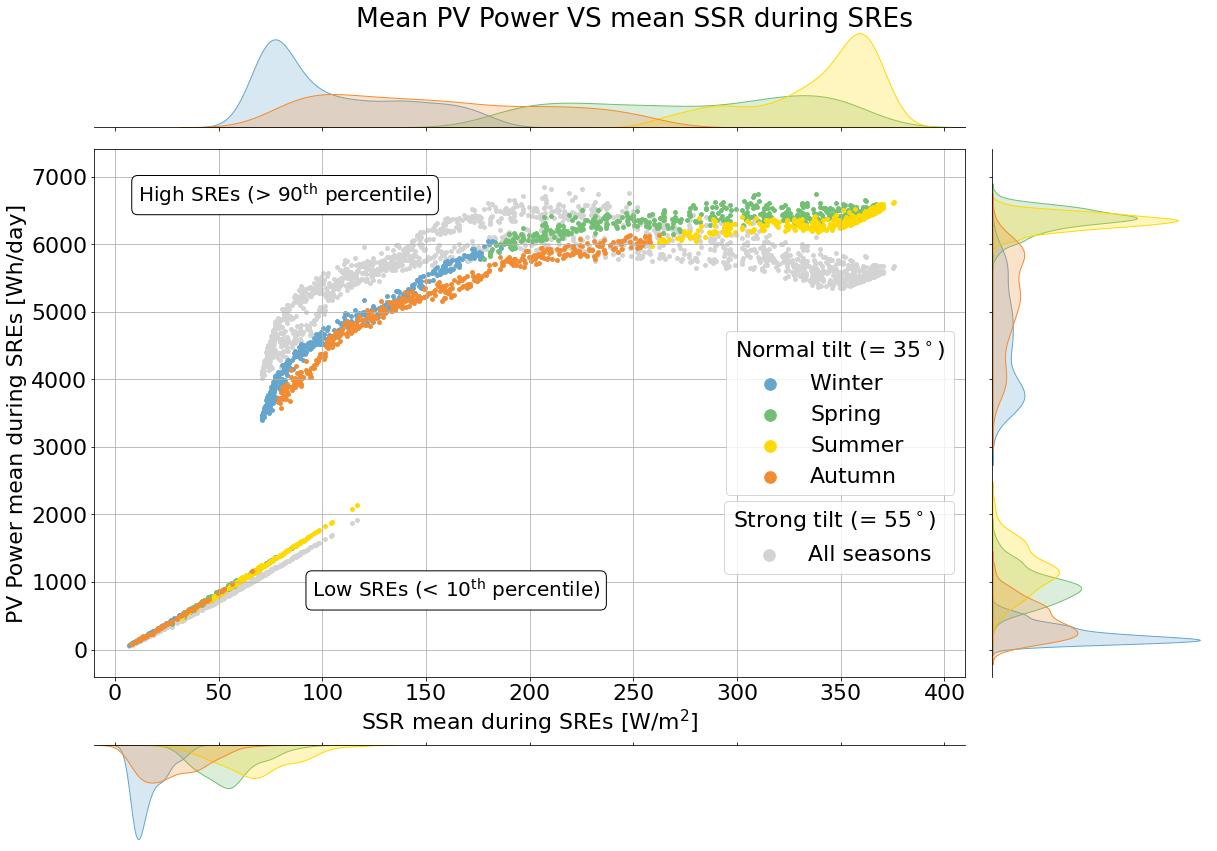

In [22]:
colors = np.array([ # Define colors associated with the different seasons
    [0.4, 0.65, 0.8],    # Winter: Sky Blue
    [0.45, 0.75, 0.45],  # Spring: Medium Green
    [1.0, 0.85, 0.0],    # Summer: Gold
    [0.95, 0.55, 0.2]    # Autumn: Dark Orange
])

labels = ['Winter       ', 'Spring', 'Summer', 'Autumn'] # Labels for the figure


fig = plt.figure(figsize=(20, 15))

fig.suptitle(f'Mean PV Power VS mean SSR during SREs').set_y(0.9)

gs = fig.add_gridspec(5, 2,  width_ratios=(4, 1), height_ratios=(0.75, 0.05, 4, 0.4, 0.75), wspace=0.05, hspace=0.05)

ax         = fig.add_subplot(gs[2, 0])  
ax_right   = fig.add_subplot(gs[2, 1], sharey=ax)
ax_bottom  = fig.add_subplot(gs[4, 0], sharex=ax)
ax_top     = fig.add_subplot(gs[0, 0], sharex=ax)

for p_index, percentile in enumerate(percentiles):

    config_num = 0 # Start with the first configuration - we are dividing into seasons and showing density on the sides

    for s, season in enumerate(seasons):

        indices = np.where(masks[season] == 1)[0] # Get all days that are within the season

        if p_index == 0: # For the first percentile (p < 50)

            ax.scatter(rsds_waves_mean[percentile][indices], power_waves_mean[percentile][0][indices], color = colors[s]  , s = 15, label = labels[s]) # Scatter plot on the main plot
            sns.kdeplot(x = rsds_waves_mean[percentile][indices]    , ax = ax_bottom, color = colors[s], shade = True)                                    # Density plot on the bottom side plot
            sns.kdeplot(y = power_waves_mean[percentile][config_num][indices], ax = ax_right , color = colors[s], shade = True)                                 # Density plot on the right side plot

        else: # For the second percentile (p > 50)

            ax.scatter(rsds_waves_mean[percentile][indices], power_waves_mean[percentile][0][indices], color = colors[s], s = 15)

            sns.kdeplot(x = rsds_waves_mean[percentile][indices] , ax = ax_top  , color = colors[s], shade = True)
            sns.kdeplot(y = power_waves_mean[percentile][config_num][indices], ax = ax_right, color = colors[s], shade = True)

    
    config_num = 1 # Continue with the second configuration - we are showing all the seasons together without density plots

    ax.scatter(rsds_waves_mean[percentile], power_waves_mean[percentile][config_num], color = 'lightgray', s = 15, zorder = 0)
    
# Set the legends
ax.legend(labels[0:4],markerscale = 3, loc = 'center right', title = "Normal tilt (= 35$^\circ$)")
handle_4 = plt.scatter([], [], color='lightgray', marker='o', s=15)
ax_top.legend([handle_4], ['All seasons'], markerscale=3, loc='center right', title="Strong tilt (= 55$^\circ$)  ", bbox_to_anchor=(1, -4.15))

# Set plot aesthetics and labels
ax.text(.25, .15, f'Low SREs (< 10$^\mathrm{{th}}$ percentile)' , horizontalalignment='left', transform=ax.transAxes, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), fontsize = 20)
ax.text(0.05, .9, f'High SREs (> 90$^\mathrm{{th}}$ percentile)', horizontalalignment='left', transform=ax.transAxes, color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'), fontsize = 20)
    
ax.set_xlabel('SSR mean during SREs [W/m$^2$]', zorder = 10)
ax.set_ylabel('PV Power mean during SREs [Wh/day]')

ax.grid()
ax.set_xlim(-10,410)
ax.set_ylim(-400,7400)

ax_right.tick_params(axis="y", labelleft=False)
ax_right.set_xticklabels('')
ax_right.set_xlabel('')
ax_right.xaxis.set_ticks([])
ax_right.yaxis.tick_left()
ax_right.spines['top'].set_visible(False)
ax_right.spines['right'].set_visible(False)
ax_right.spines['left'].set_visible(True)
ax_right.spines['bottom'].set_visible(False)

ax_top.set_ylabel('')
ax_top.yaxis.set_ticks([])
ax_top.yaxis.tick_left()
ax_top.spines['top'].set_visible(False)
ax_top.spines['right'].set_visible(False)
ax_top.spines['left'].set_visible(False)
ax_top.spines['bottom'].set_visible(True)
ax_top.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)

ax_bottom.tick_params(axis="x", labelbottom=True)
ax_bottom.set_ylabel('')
ax_bottom.set_yticks([])
ax_bottom.set_yticklabels('')
ax_bottom.set_ylabel('')
ax_bottom.yaxis.set_ticks([])
ax_bottom.yaxis.tick_left()
ax_bottom.spines['top'].set_visible(True)
ax_bottom.spines['right'].set_visible(False)
ax_bottom.spines['left'].set_visible(False)
ax_bottom.spines['bottom'].set_visible(False)
ax_bottom.xaxis.tick_top()
ax_bottom.invert_yaxis()
ax_bottom.xaxis.set_ticks_position('top')
ax_bottom.tick_params(axis='x', which='both', bottom=False, top=True, labeltop=False)


plt.savefig(f'Figures/PV_Analysis/correlation_PV.png', bbox_inches='tight')

plt.show()

---
## Pearson Correlation Coefficient Computation

We are computing for each configuration and each percentile the Pearson correlation coefficient.

In [28]:
for num_config, config_details in configs.items():

    for percentile in percentiles:

        SREs_all_years = output_SREs[percentile]['SREs_all_years']

        indices = np.where((SREs_all_years > 2))[0]

        x = power_waves_mean[percentile][num_config][indices]
        y = rsds_waves_mean[percentile][indices]
        
        correlation = np.corrcoef(x, y)[0,1]

        print(f'config {num_config}, percentile {percentile} : {correlation:.6f}')

config 0, percentile 10 : 0.999300
config 0, percentile 90 : 0.908131
config 1, percentile 10 : 0.999086
config 1, percentile 90 : 0.450260
